# 使用数字代替文本 

## one-hot向量

使用one-hot向量十分低效，one-hot向量十分稀疏，大部分都是0
并且随着词汇表大小的增加，one-hot向量的维度也会不断变大

## 使用单独的数字进行编码

我们对每一个单词进行编码，每一个单词对应一个数字，这样虽然十分高效，但是：
1. 使用一个数字编码一个单词过于绝对，这样不能获得到单词间的联系
2. 使用一个数字是的模型对于该单词解释过于困难。如线性分类器为每个特征学习单个权重。因为两个单词之间的相似性与其编码之间的相似性没有任何关系，这种特征权重的组合是没有意义的

## word embedding

词嵌入为我们提供了一种使用高效、密集表示的方法，其中相似的单词具有相似的编码。重要的是，我们不必手工指定这种编码。嵌入是浮点值的密集向量（向量的长度是您指定的参数）。它们不是手动指定嵌入的值，而是可训练的参数（训练期间模型学习的权重，与模型学习稠密层权重的方式相同）。在处理大型数据集时，常见的词嵌入是8维的（对于小型数据集），最多可达1024维。更高维度的嵌入可以捕获单词之间的细粒度关系，但需要更多的数据来学习。

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


对于此数据集，进行一点说明，只是我自己的想法，此文本编码器将可逆地对任何字符串进行编码，必要时返回字节编码。  
有些词汇并不在我们最终训练的词汇表中。
最终的词汇表里面有写并不是一个完整的单词。
可能是 因为词汇表只有8185.可能有些词语没有收录，就只能对该单词部分字节编码了（词汇表中包含了用于构建一些大单词的部分词根，所以可以构建任何单词。）  
比如词汇表中没有tensorflow，就会将其拆分为单词表中有的'ten'+'sor'+'fl'+'ow'这四部分词根

In [4]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:
单词后面的_代表的是空格，词汇表中还会看到一些部分单词，这代表的是用于构建一些单词的部分词根，如‘br’，‘er’等

In [5]:
encoder=info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [6]:
for i in train_data.take(5):
    print(i)

(<tf.Tensor: shape=(855,), dtype=int64, numpy=
array([ 249,    4,  277,  309,  560,    6, 6639, 4574,    2,   12,   31,
       7759, 3525, 2128,   93, 2306,   43, 2312, 2527,    6,   30, 1334,
       8044,   24,   10,   16,   10,   17,  977,   30,  815, 3339,   41,
        841, 7911,  376, 7974, 1923,    6,  607,  219,   44,  242, 1603,
         11, 4329,  102, 2821, 1139,    2,  969,  161,   51,   18,    4,
       5844, 2820,  123, 4493,   40,    6, 4571,   13,  117,   35,  289,
        850,  455,   50,  460, 6359, 1069,  343,   20,    1, 3733, 3511,
       7670,    3,  147,    4,  336,    2,   42,   18,    4, 3422,  409,
       3533,  871, 2836,  311,    5, 5080, 1209,    3,  183,  117,   35,
       1187,    5, 1955,   11,    1,  226, 7745,    3,  183, 1466, 7359,
       7961, 1466,  665,    2, 6854, 3178, 1377, 6266, 1447,  297,    2,
       5797,   36, 4740,  847, 8050,    2,    5, 1929, 1631, 5986,   22,
       5541, 5688,    5, 1036, 3746, 8050,    3,   69,  264,   35,    4,
    

In [7]:
# 使用padded_batch方法来标准化评论的长度
padded_shapes=([None],())
train_batchs=train_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)
test_batchs=test_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)

In [8]:
# 样本都被padding到了每一批中最长的样本长度
train_batch,train_label=next(iter(train_batchs))
train_batch.numpy(),train_batch.numpy().shape

(array([[7522, 4943,    9, ...,    0,    0,    0],
        [  12,  800,  359, ...,    0,    0,    0],
        [7963,   19, 6957, ...,    0,    0,    0],
        ...,
        [  19,   27,  732, ...,    0,    0,    0],
        [ 133,  822, 1890, ...,    0,    0,    0],
        [7989,   10,   16, ...,    0,    0,    0]]), (10, 382))

### 创建连续词袋模型 

1. 接下来，嵌入层采用整数编码的词汇表，并查找每个单词索引的嵌入向量。这些向量作为模型训练来学习。嵌入向量向输出数组添加一个维度。生成的维度是：（批处理、序列、嵌入）。 
2. 接下来，GlobalAveragePooling1D层通过在序列维度上求平均值来为每个示例返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。
3. 这个固定长度的输出向量通过一个具有16个隐藏单元的完全连接（密集）层进行管道传输。
4. 最后一层与单个输出节点紧密连接。使用sigmoid激活函数，这个值是介于0和1之间的一个浮点数，表示评审为正的概率（或置信水平）。

In [9]:
embedding_dim=50
model=keras.Sequential([
    layers.Embedding(encoder.vocab_size,embedding_dim),
    layers.GlobalAveragePooling1D(),
    # 删除这一层，模型更加简单，获得的词向量更具有解释性
#     layers.Dense(16,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          409250    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 409,301
Trainable params: 409,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
checkpoint_save_path = "./word_embedding/word_embedding.ckpt"

# 用于加载模型，checkpoint中保存好了已经训练好了的模型权重，加载之后可以不用训练了
# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------load the model-----------------')
#     model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 # monitor='loss',
                                                 # save_best_only=True,
                                                 verbose=2)

In [15]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history=model.fit(train_batchs,validation_data=test_batchs,epochs=10,callbacks=[cp_callback])

Epoch 1/10
   2500/Unknown - 13s 5ms/step - loss: 0.5815 - accuracy: 0.7359
Epoch 00001: saving model to ./word_embedding/word_embedding.ckpt
2500/2500 [==============================] - 16s 6ms/step - loss: 0.5815 - accuracy: 0.7359 - val_loss: 0.4584 - val_accuracy: 0.8372
Epoch 2/10
2487/2500 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8696
Epoch 00002: saving model to ./word_embedding/word_embedding.ckpt
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3735 - accuracy: 0.8699 - val_loss: 0.3569 - val_accuracy: 0.8682
Epoch 3/10
2485/2500 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8981
Epoch 00003: saving model to ./word_embedding/word_embedding.ckpt
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2934 - accuracy: 0.8979 - val_loss: 0.3241 - val_accuracy: 0.8776
Epoch 4/10
2490/2500 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.9119
Epoch 00004: saving model to .

In [169]:
import pandas as pd
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.202403,0.93136,0.312740,0.87992,5
6,0.187597,0.93800,0.328004,0.87992,6
7,0.171211,0.94360,0.336856,0.87812,7
8,0.160657,0.94848,0.346631,0.87600,8
9,0.147951,0.95196,0.366205,0.87292,9


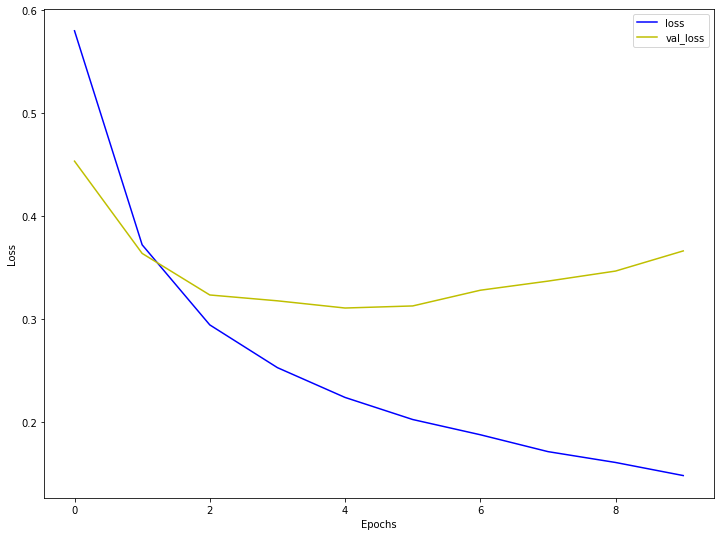

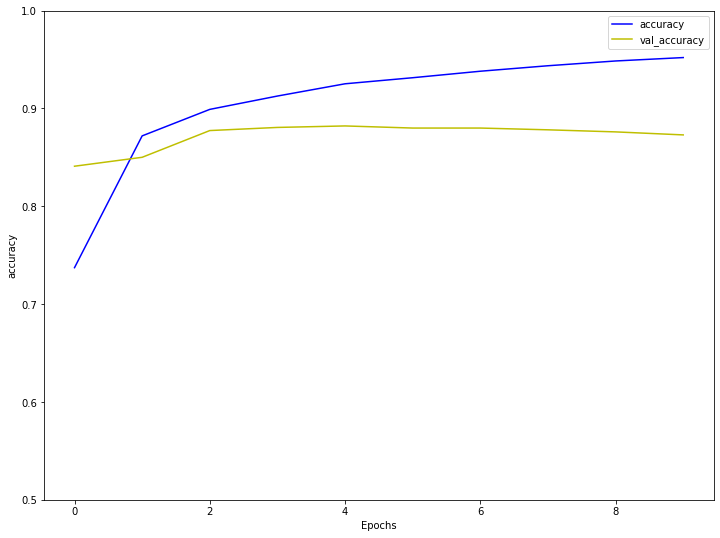

In [170]:
import matplotlib.pyplot as plt

def plot_histrory(hist):
    acc=hist['accuracy']
    val_acc=hist['val_accuracy']
    loss=hist['loss']
    val_loss=hist['val_loss']
    epochs=hist['epoch']
    
    plt.figure(figsize=(12,9))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs,loss,'b',label='loss')
    plt.plot(epochs,val_loss,'y',label='val_loss')
    plt.legend()
    
    plt.figure(figsize=(12,9))
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs,acc,'b',label='accuracy')
    plt.plot(epochs,val_acc,'y',label='val_accuracy')
    plt.ylim((0.5,1))
    plt.legend()
    plt.show()
    
plot_histrory(hist)
    


过拟合了，应该使用early stop

## 取回训练后的词向量

In [13]:
# 词向量的维度是（vocab_size,embeddind_dim)
embedding=model.layers[0]
weights=embedding.get_weights()[0]
print(weights.shape)
# # shape: (vocab_size, embedding_dim)

(8185, 50)


In [14]:
weights

array([[-0.00200098, -0.00894768,  0.0265508 , ..., -0.04243807,
        -0.00289176,  0.04330957],
       [ 0.02415383, -0.04092653,  0.01354494, ...,  0.00343876,
        -0.04074351, -0.01056439],
       [-0.00155406, -0.00306863, -0.04088452, ..., -0.04048749,
        -0.03588666,  0.01566445],
       ...,
       [-0.0021259 , -0.03626452,  0.02365471, ..., -0.02907554,
        -0.02835467,  0.02194622],
       [ 0.01962468,  0.01224951, -0.00076783, ...,  0.02989665,
         0.00915754, -0.01785647],
       [-0.03002352, -0.01256516,  0.04654053, ..., -0.03256654,
         0.03335262, -0.02600336]], dtype=float32)

In [12]:
# 将得到的词向量与对于单词保存到文本中
# 以下代码来自于官方教程，但是我认为这是错误的
# 以至于之后我找最后最接近的10个单词结果很诡异
# 词汇表中第一个单词是'the_'
# 时间上这个单词对应的编码是[181, 8024]
# 单词the对应的是 181，‘_'对应8024
# 这样也就可以解释subwords只有7928个，voabsize是8025
# 当然，以上只是我个人想法，也许我没有理解官方教程的意思

vecs=[]
import io
encoder=info.features['text'].encoder
out_v=io.open('word_embedding/vecs.tsv','w',encoding='utf-8')
out_m=io.open('word_embedding/meta.tsv','w',encoding='utf-8')
for num, word in enumerate(encoder.subwords):
#     vec = weights[num+1] # skip 0, it's padding.
    # 我认为正确的
    vec=weights[encoder.encode(word)]
    if len(vec)==1:
        vecs.append(vec)
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

## 找最相似的10个单词

In [21]:
len(encoder.subwords),encoder.vocab_size #encoder中遍历单词个数与vocab_size不一致
# 原因是 subwords包含的是单词以及部分词根，而词汇表中包含了一些符号，如'_',','等等

(7928, 8185)

In [22]:
import numpy as np

In [23]:
# 计算两个词向量的距离
def calDistance(x1,x2):
    return np.sum(np.square(x1-x2))

In [24]:
#  构建距离矩阵
def build_distance_matrix(vec):
    # 距离矩阵
    D=[[0 for _ in range(len(vec))] for _ in range(len(vec))]
    # 注意矩阵是关于对角线对称的，只需要计算上三角
    for i in range(len(vec)):
        if i%100==0:
            print('*',end=' ')
        for j in range(i,len(vec)):
            dis=calDistance(vec[i],vec[j])
            D[i][j]=dis
            D[j][i]=dis
    return D

In [25]:
# 获得单词与其对应的索引
def get_index_and_word(encoder):
    vocabulary=[]
    for word in encoder.subwords:
        if word[-1]=='_' or word[-1]==' ':
            word=word[:-1] #去掉最后的‘_'
        # 这个index才是单词在embedding层中真正对应的index
        index=encoder.encode(word)
        vocabulary.append((index,word))
    return vocabulary

In [26]:
# 包含了（index，word）其中index是embeding层中对应的index
vocab=get_index_and_word(encoder)

In [27]:
index,word=vocab[0]
print(index)
print(word)

[181]
the


In [28]:
vec=[]
words=[]
# 下面依据index构建词向量矩阵与单词矩阵
for (index,word) in vocab:
    
    #  注意有些词是合成的，所以有多个index，对于这些词，就不管了
    if len(index)==1 and word not in words:
        vec.append(weights[index[0]])
        words.append(word)
print(len(vec))

5375


In [29]:
words.index('good'),words.index('bad'),words.index('nice')

(68, 121, 355)

In [30]:
# 测试一下 good 与 nice，应该很接近
# good与bad很远
print(f'distance between {words[68]} and {words[121]} is {calDistance(vec[68],vec[121])})')
print(f'distance between {words[68]} and {words[355]} is {calDistance(vec[68],vec[355])})')



distance between good and bad is 0.0956316590309143)
distance between good and nice is 0.08410060405731201)


In [31]:
D=build_distance_matrix(vec)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

In [32]:

test_word='wonderful'
test_index=words.index(test_word)
test_index,vec[test_index]

(449, array([-0.02377599,  0.00275905,  0.02319555,  0.02774049, -0.03836197,
         0.04281512, -0.04666506, -0.01896515,  0.03093101,  0.01542311,
         0.01980628, -0.01423657,  0.01552382,  0.02122546,  0.03555961,
         0.00566257, -0.00109243, -0.04521679, -0.02438644, -0.019045  ,
        -0.04493141, -0.02218024, -0.00071688, -0.00735792, -0.01323647,
         0.00185458, -0.02730581, -0.03230695, -0.00534117, -0.00681255,
        -0.0334829 ,  0.02243051, -0.01931681,  0.03493777, -0.02028063,
        -0.03062285,  0.00385151,  0.01561116,  0.01407261,  0.04348997,
        -0.04264944,  0.04783405, -0.01494684,  0.04420594,  0.0337046 ,
        -0.02745975, -0.04202387,  0.04675582,  0.0251516 , -0.00010511],
       dtype=float32))

In [33]:
def find_top_10(D,index):
    dis=D[index] # 获得了测试单词词向量到所有单词词向量的距离
    
    #下面我们需要找到distances中最小的k个元素，并且返回他们的索引就可以了
    # argsort函数返回的是数组值从小到大的索引值
    # 将distances变为np.array，然后对索引排序，取前k个
    minK=np.argsort(np.array(dis))[:10]
    print(minK)
    result=[]
    for i in range(10):
        result.append(words[minK[i]])
    return result

In [35]:
# 每次的结果都不一定，与训练的epoch，embedding层的初始化有关
find_top_10(D,test_index)

[ 449  196  608 5048 2357 3636   99 3756  153 5039]


['wonderful',
 'why',
 'ig',
 'rah',
 'appearance',
 'stan',
 'other',
 'corny',
 'There',
 '!!!!!!']

## 可视化

1. 可以使用tensorboard

2. Open the Embedding Projector(http://projector.tensorflow.org) (this can also run in a local TensorBoard instance).

Click on "Load data".
Upload the two files we created above: vecs.tsv and meta.tsv.
The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".